# Machine Learning Pipeline
This notebook is inspired after reading https://www.quantopian.com/posts/machine-learning-on-quantopian. But I made some modification in making the model regressing instead of classifying. Also I added some other factors. My Machine Learning Pipeline has not been implemented as algorithm in IDE yet. Clearly long training time is the biggest problem in implementing the machine learning pipeline in an algorithm. In the following example, the processing dataset took a little more than 1 minute, and training the model took about 10 minutes.

But for right now I think it helps a lot in low to medium frequency trading (such as weekly or biweekly).

### Prepare data for X's (predictors)
Start from common factors shown in https://www.quantopian.com/posts/machine-learning-on-quantopian, I added moving average of sentiment and some scores from Monrningstar Fundamentals.

*Remark:* Using sentiment actually did not explain much of the variance in predicted values, which was a little surprise for me.

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time


from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import Q1500US, Q500US
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.classifiers.morningstar import Sector
#from quantopian.pipeline.data.zacks import EarningsSurprises
#from quantopian.pipeline.data.sentdex import sentiment


from quantopian.pipeline.factors import (
    Returns,
    MaxDrawdown,
    CustomFactor,
    SimpleMovingAverage,
    AverageDollarVolume,
    RSI,
    Latest, 
    MACDSignal
)



def make_factors():
    bs = morningstar.balance_sheet
    cfs = morningstar.cash_flow_statement
    is_ = morningstar.income_statement
    or_ = morningstar.operation_ratios
    er = morningstar.earnings_report
    v = morningstar.valuation
    vr = morningstar.valuation_ratios
    sector = morningstar.Fundamentals.morningstar_sector_code

    def Asset_Growth_3M():
        return Returns(inputs=[bs.total_assets], window_length=63)

    def Asset_To_Equity_Ratio():
        return bs.total_assets.latest / bs.common_stock_equity.latest

    def Capex_To_Cashflows():
        return (cfs.capital_expenditure.latest * 4.) / (cfs.free_cash_flow.latest * 4.)
        
    def EBITDA_Yield():
        return (is_.ebitda.latest * 4.) / USEquityPricing.close.latest        

    def EBIT_To_Assets():
        return (is_.ebit.latest * 4.) / bs.total_assets.latest
        
    def Earnings_Quality():
        return morningstar.cash_flow_statement.operating_cash_flow.latest / EarningsSurprises.eps_act.latest
        
    def Return_On_Total_Invest_Capital():
        return or_.roic.latest
    
    def Revenue_Growth():
        return or_.revenue_growth.latest
    
    def PB_Ratio():
        return vr.pb_ratio.latest
    
    def PE_Ratio():
        return vr.pe_ratio.latest
    
    def ROA():
        return or_.roa.latest
    
    class Mean_Reversion_1M(CustomFactor):
        inputs = [Returns(window_length=21)]
        window_length = 252

        def compute(self, today, assets, out, monthly_rets):
            out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / \
                np.nanstd(monthly_rets, axis=0)
                
    class MACD_Signal_10d(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 60

        def compute(self, today, assets, out, close):

            sig_lines = []

            for col in close.T:
                # get signal line only
                try:
                    _, signal_line, _ = talib.MACD(col, fastperiod=12,
                                                   slowperiod=26, signalperiod=10)
                    sig_lines.append(signal_line[-1])
                # if error calculating, return NaN
                except:
                    sig_lines.append(np.nan)
            out[:] = sig_lines 
            
    class Moneyflow_Volume_nd(CustomFactor):
        inputs = [USEquityPricing.close, USEquityPricing.volume]
        window_length = 5

        def compute(self, today, assets, out, close, volume):

            mfvs = []

            for col_c, col_v in zip(close.T, volume.T):

                # denominator
                denominator = np.dot(col_c, col_v)

                # numerator
                numerator = 0.
                for n, price in enumerate(col_c.tolist()):
                    if price > col_c[n - 1]:
                        numerator += price * col_v[n]
                    else:
                        numerator -= price * col_v[n]

                mfvs.append(numerator / denominator)
            out[:] = mfvs  
            
           
    def Net_Income_Margin():
        return or_.net_margin.latest           

    def Operating_Cashflows_To_Assets():
        return (cfs.operating_cash_flow.latest * 4.) / \
            bs.total_assets.latest

    def Price_Momentum_3M():
        return Returns(window_length=63)
    
    class Price_Oscillator(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 25#2

        def compute(self, today, assets, out, close):
            four_week_period = close[-2:]
            out[:] = (np.nanmean(four_week_period, axis=0) /
                      np.nanmean(close, axis=0)) - 1.
    
    def Returns_39W():
        return Returns(window_length=215)
    
    class Trendline(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        # using MLE for speed
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / \
                (self.window_length)
        
    class Vol_3M(CustomFactor):
        inputs = [Returns(window_length=2)]
        window_length = 63

        def compute(self, today, assets, out, rets):
            out[:] = np.nanstd(rets, axis=0)
            
    def Working_Capital_To_Assets():
        return bs.working_capital.latest / bs.total_assets.latest
    
    def MACD_Signal():
        return MACDSignal()
    
    
    def Sentiment_SMA():
        return SimpleMovingAverage(inputs=[sentiment.sentiment_signal], window_length=15)      
    def Growth_score():
        return morningstar.Fundamentals.growth_score.latest
    def Size_score():
        return morningstar.Fundamentals.size_score.latest
    def Style_score():
        return morningstar.Fundamentals.style_score.latest
    def Value_score():
        return morningstar.Fundamentals.value_score.latest
    
    all_factors = {
#       'Sentiment': Sentiment_SMA,
        'MACD': MACD_Signal,
        'Asset Growth 3M': Asset_Growth_3M,
        'Asset to Equity Ratio': Asset_To_Equity_Ratio,
        'Capex to Cashflows': Capex_To_Cashflows,
        'EBIT to Assets': EBIT_To_Assets,
        'EBITDA Yield': EBITDA_Yield,        
        'Mean Reversion 1M': Mean_Reversion_1M,
        'Moneyflow Volume ND': Moneyflow_Volume_nd,
        'Net Income Margin': Net_Income_Margin,        
        'Operating Cashflows to Assets': Operating_Cashflows_To_Assets,
        'Price Momentum 3M': Price_Momentum_3M,
        'Price Oscillator': Price_Oscillator,
        'Return on Invest Capital': Return_On_Total_Invest_Capital,
        '39 Week Returns': Returns_39W,
        'Trendline': Trendline,
        'Vol 3M': Vol_3M,
        'Working Capital to Assets': Working_Capital_To_Assets,  
#        'EPS Surprise': EPSGrowth # Holdout 1 year...
        'Revenue Growth': Revenue_Growth,
        'PB Ratio': PB_Ratio,
        'PE Ratio': PE_Ratio,
        'ROA': ROA,
#        'Growth': Growth_score,
#        'Size': Size_score,
#        'Style': Style_score,
#        'Value': Value_score
    }        
    
    return all_factors

ModuleNotFoundError: No module named 'quantopian'

### Define and build the pipeline
I tried running the pipeline from 2019-09-19 to 2020-06-19, and it already gave me round 10,000 data points.

In [86]:
factors = make_factors()
start_processing = time.time()

n_fwd_days = 30 # predict rate of return 5 days in the future
universe = Q500US()

def make_history_pipeline(factors, universe, n_fwd_days=5):
    # Call .rank() on all factors and mask out the universe
    factor_ranks = {name: f() for name, f in factors.items()}
    # Get cumulative returns over last n_fwd_days days. We will later shift these.
    
    pipe = Pipeline(screen=universe, columns=factor_ranks)
    
    return pipe

pipeline = make_history_pipeline(factors, universe, n_fwd_days=n_fwd_days)
start, end = '2017-06-20', '2020-10-20'
results = run_pipeline(pipeline, start_date=start, end_date=end)

In [87]:
results.head(10)

39 Week Returns  \
2017-06-20 00:00:00+00:00 Equity(2 [HWM])           -0.140060   
                          Equity(24 [AAPL])          0.374868   
                          Equity(62 [ABT])           0.104973   
                          Equity(67 [ADSK])          0.720583   
                          Equity(76 [TAP])          -0.115894   
                          Equity(114 [ADBE])         0.380348   
                          Equity(122 [ADI])          0.282848   
                          Equity(128 [ADM])         -0.006291   
                          Equity(161 [AEP])          0.093716   
                          Equity(168 [AET])          0.282239   

                                              Asset Growth 3M  \
2017-06-20 00:00:00+00:00 Equity(2 [HWM])           -0.461734   
                          Equity(24 [AAPL])          0.010240   
                          Equity(62 [ABT])           0.345973   
                          Equity(67 [ADSK])         -0.076426   
                          Equity(76 [TAP])           0.006864   
                          Equity(114 [ADBE])         0.000000   
                          Equity(122 [ADI])          1.609205   
                          Equity(128 [ADM])         -0.003495   
                          Equity(161 [AEP])         -0.027406   
                          Equity(168 [AET])         -0.185043   

                                              Asset to Equity Ratio  \
2017-06-20 00:00:00+00:00 Equity(2 [HWM])                  3.716261   
                          Equity(24 [AAPL])                2.494981   
                          Equity(62 [ABT])                 2.260283   
                          Equity(67 [ADSK])                8.721512   
                          Equity(76 [TAP])                 2.547175   
                          Equity(114 [ADBE])               1.718977   
                          Equity(122 [ADI])                2.671191   
                          Equity(128 [ADM])                2.314701   
                          Equity(161 [AEP])                3.490018   
                          Equity(168 [AET])                3.951406   

                                              Capex to Cashflows  \
2017-06-20 00:00:00+00:00 Equity(2 [HWM])               0.255583   
                          Equity(24 [AAPL])            -0.317101   
                          Equity(62 [ABT])             -0.900662   
                          Equity(67 [ADSK])            -0.234973   
                          Equity(76 [TAP])              0.603419   
                          Equity(114 [ADBE])           -0.044181   
                          Equity(122 [ADI])            -0.098895   
                          Equity(128 [ADM])            -0.956938   
                          Equity(161 [AEP])             2.433801   
                          Equity(168 [AET])            -0.085749   

                                              EBIT to Assets  EBITDA Yield  \
2017-06-20 00:00:00+00:00 Equity(2 [HWM])           0.118867  1.100752e+08   
                          Equity(24 [AAPL])         0.181914  4.794317e+08   
                          Equity(62 [ABT])          0.054284  1.420913e+08   
                          Equity(67 [ADSK])        -0.107957 -3.436323e+06   
                          Equity(76 [TAP])          0.049988  2.616006e+07   
                          Equity(114 [ADBE])        0.146806  1.594901e+07   
                          Equity(122 [ADI])         0.023792  1.472649e+07   
                          Equity(128 [ADM])         0.054403  7.204149e+07   
                          Equity(161 [AEP])         0.073367  9.155864e+07   
                          Equity(168 [AET])        -0.032298 -7.781075e+06   

                                                  MACD  Mean Reversion 1M  \
2017-06-20 00:00:00+00:00 Equity(2 [HWM])    -0.138331          -0.300795   
                          Equity(24 [AAPL])  -1.809351          -1.560

In [88]:
results.tail(10)

39 Week Returns  \
2020-10-20 00:00:00+00:00 Equity(53379 [LVGO])         4.292510   
                          Equity(53403 [DT])           0.844828   
                          Equity(53480 [NET])          2.303288   
                          Equity(53511 [DDOG])         2.123846   
                          Equity(53535 [PTON])         3.316721   
                          Equity(53775 [BILL])              NaN   
                          Equity(54055 [OTIS])              NaN   
                          Equity(54057 [CARR])              NaN   
                          Equity(54353 [MTCH])              NaN   
                          Equity(54483 [RKT])               NaN   

                                                Asset Growth 3M  \
2020-10-20 00:00:00+00:00 Equity(53379 [LVGO])              0.0   
                          Equity(53403 [DT])                0.0   
                          Equity(53480 [NET])               0.0   
                          Equity(53511 [DDOG])              0.0   
                          Equity(53535 [PTON])              0.0   
                          Equity(53775 [BILL])              0.0   
                          Equity(54055 [OTIS])              0.0   
                          Equity(54057 [CARR])              0.0   
                          Equity(54353 [MTCH])              0.0   
                          Equity(54483 [RKT])               0.0   

                                                Asset to Equity Ratio  \
2020-10-20 00:00:00+00:00 Equity(53379 [LVGO])               1.814986   
                          Equity(53403 [DT])                 2.070481   
                          Equity(53480 [NET])                1.632391   
                          Equity(53511 [DDOG])               1.953952   
                          Equity(53535 [PTON])               1.776996   
                          Equity(53775 [BILL])               3.382511   
                          Equity(54055 [OTIS])              -2.461339   
                          Equity(54057 [CARR])               6.001986   
                          Equity(54353 [MTCH])              -1.366799   
                          Equity(54483 [RKT])                5.215240   

                                                Capex to Cashflows  \
2020-10-20 00:00:00+00:00 Equity(53379 [LVGO])           -1.577971   
                          Equity(53403 [DT])             -0.140146   
                          Equity(53480 [NET])             1.197827   
                          Equity(53511 [DDOG])           -0.329786   
                          Equity(53535 [PTON])           -0.164769   
                          Equity(53775 [BILL])            0.841386   
                          Equity(54055 [OTIS])           -0.057325   
                          Equity(54057 [CARR])           -0.099352   
                          Equity(54353 [MTCH])           -0.111065   
                          Equity(54483 [RKT])             0.010074   

                                                EBIT to Assets  EBITDA Yield  \
2020-10-20 00:00:00+00:00 Equity(53379 [LVGO])        0.002516  7.790649e+04   
                          Equity(53403 [DT])          0.047146  3.531707e+06   
                          Equity(53480 [NET])        -0.067640 -7.905269e+05   
                          Equity(53511 [DDOG])        0.011482  3.163374e+05   
                          Equity(53535 [PTON])        0.120598  3.065699e+06   
                          Equity(53775 [BILL])       -0.015750 -2.901880e+05   
                          Equity(54055 [OTIS])        0.159372  2.889545e+07   
                          Equity(54057 [CARR])        0.076109  6.658416e+07   
                          Equity(54353 [MTCH])        0.364931  7.896389e+06   
                          Equity(54483 [RKT])              NaN           NaN   

                                                     MACD  Mean Reversion 1M  \
2020-10-20 00:00:00+00:00 Equity(533

### Retrieve Y's (predicted values)

In [89]:
# Retrieve ND return rate by...
from quantopian.research import returns
returns_data = returns(
  assets=results.index.levels[1], # Finds all assets that appear at least once in "factor_data"  
  start=results.index.levels[0][n_fwd_days],
  end=end, # must be after run_pipeline()'s end date. Explained more in lesson 4
  periods = 5,
  price_field='open' # Generally, you should use open pricing. Explained more in lesson 4
)

print(returns_data.shape) 

(811, 735)


### Concatnate predicted values and predictors
Here is the most tricky part. Quantopian pipeline can only give us Return or Price at current time point — getting future information is not possible. The work-around I figured out is that we could append a new column ("Return 5D") to the dataframe containing all predictors for all assets per day, and assign each of the predicted value to its corresponding row (matching date and asset). It took me a while to figure a way out to work with Pandas multi-index dataframe. 

**Please tell me if you see any bug! And also any suggestions to optimize!**

In [90]:
results_w_returns = results.loc[results.index.levels[0][:len(results.index.levels[0])-n_fwd_days].tolist()].copy()
results_w_returns["Returns 5D"] = np.nan

dates = results.index.levels[0][:len(results.index.levels[0])-n_fwd_days]
i = 0
for date in dates:
    results_day = results_w_returns.loc[date]
    assets = results_day.index
    for asset in assets:
        if len(results_day) > 0:
            results_w_returns.loc[(date, asset)]['Returns 5D'] = returns_data.iloc[i][asset]
    i += 1
    
data_processing_time = time.time() - start_processing
print('processing data took', round(data_processing_time, 2), 'seconds')

processing data took 437.99 seconds


In [98]:
dataset = results_w_returns.dropna()
Y = np.array(dataset.pop('Returns 5D'))
dataset['EBITDA Yield'] /= dataset['EBITDA Yield'].mean()
X = np.array(dataset)
dataset.head()
dataset.shape

/venvs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(343845, 21)

Done! We accomplished the most important intriguing in this machine learning pipeline :) The next would be pretty standard: model selection, fine-tuning hyperparameters, model validation and assessment.

In [124]:
print(dataset.isnull().sum()) #Check NAs

39 Week Returns                  0
Asset Growth 3M                  0
Asset to Equity Ratio            0
Capex to Cashflows               0
EBIT to Assets                   0
EBITDA Yield                     0
MACD                             0
Mean Reversion 1M                0
Moneyflow Volume ND              0
Net Income Margin                0
Operating Cashflows to Assets    0
PB Ratio                         0
PE Ratio                         0
Price Momentum 3M                0
Price Oscillator                 0
ROA                              0
Return on Invest Capital         0
Revenue Growth                   0
Trendline                        0
Vol 3M                           0
Working Capital to Assets        0
dtype: int64


In [114]:
print(np.isfinite(dataset).sum()) #Check finity

39 Week Returns                  343845
Asset Growth 3M                  343845
Asset to Equity Ratio            343845
Capex to Cashflows               343774
EBIT to Assets                   343845
EBITDA Yield                     343845
MACD                             343845
Mean Reversion 1M                343845
Moneyflow Volume ND              343845
Net Income Margin                343845
Operating Cashflows to Assets    343845
PB Ratio                         343845
PE Ratio                         343845
Price Momentum 3M                343845
Price Oscillator                 343845
ROA                              343845
Return on Invest Capital         343845
Revenue Growth                   343845
Trendline                        343845
Vol 3M                           343845
Working Capital to Assets        343845
dtype: int64


In [125]:
dataset = dataset.replace([np.inf, -np.inf], np.nan).dropna(axis=0)


In [126]:
print(np.isfinite(dataset).sum())

39 Week Returns                  343774
Asset Growth 3M                  343774
Asset to Equity Ratio            343774
Capex to Cashflows               343774
EBIT to Assets                   343774
EBITDA Yield                     343774
MACD                             343774
Mean Reversion 1M                343774
Moneyflow Volume ND              343774
Net Income Margin                343774
Operating Cashflows to Assets    343774
PB Ratio                         343774
PE Ratio                         343774
Price Momentum 3M                343774
Price Oscillator                 343774
ROA                              343774
Return on Invest Capital         343774
Revenue Growth                   343774
Trendline                        343774
Vol 3M                           343774
Working Capital to Assets        343774
dtype: int64


In [127]:
dataset.shape

(343774, 21)

### Training machine learning model

In [128]:
# Train-test split
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

(240691, 21) (103154, 21)


I tried a few regression models such as Ridge regression, KNN regression, SVM, and without surprise, **Random Forest** had the best performance.

In [129]:
from sklearn import svm
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
start_time = time.time()

model = RandomForestRegressor(n_estimators=100)
# model = svm.SVR()
model.fit(X_train, Y_train)
training_time = time.time() - start_preprocess
print('training model took', round(training_time, 2), 'seconds')

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [22]:
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
Y_pred = model.predict(X_test)
Y_pred

array([-0.00086344, -0.00245894, -0.00656036, ..., -0.12015546,
        0.0425654 ,  0.11050736])

### Model Assessment
Because this is a regression model, the first step I did was to assess the model calibration.

Using operator model to sort list with tuples, we can color points with top-n/bottom-n return rates, and we can make long positions on the top-n observations, and short positions on bottom-n observations.

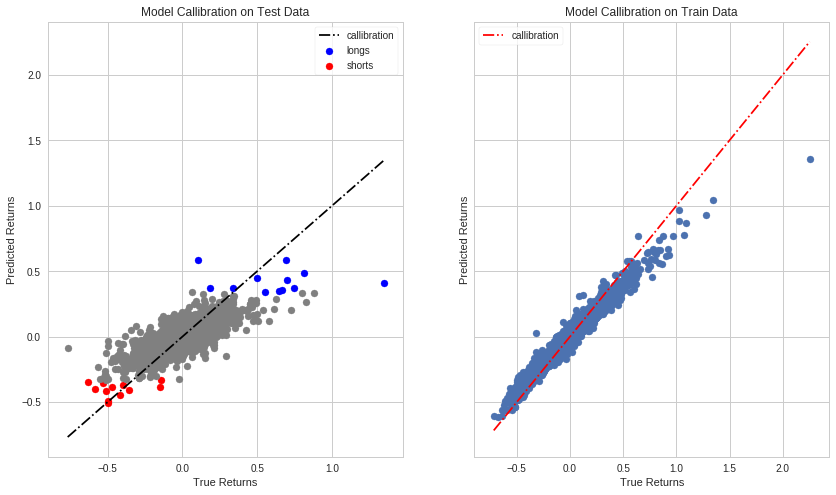

In [23]:
import operator
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
x_test = np.linspace(min(Y_test), max(Y_test), 10)
x_train = np.linspace(min(Y_train), max(Y_train), 10)

test_result = [(0, 0)] * len(Y_test)
for i in range(len(Y_test)):
    test_result[i] = (Y_test[i], Y_pred[i])
    
# sort by predicted profits
test_result.sort(key = operator.itemgetter(1), reverse = True)

longs = np.array(test_result[:12])
shorts = np.array(test_result[-12:])
rest = np.array(test_result[12:-12])

ax1.plot(x_test, x_test, color = "black", linestyle = 'dashdot')
ax1.scatter(longs[:,0],longs[:,1], color = 'blue')
ax1.scatter(shorts[:,0],shorts[:,1], color = 'red')
ax1.scatter(rest[:,0],rest[:,1], color = 'gray')
ax1.legend(["callibration", "longs", "shorts"])
ax1.set_title("Model Callibration on Test Data")
ax1.set_xlabel("True Returns")
ax1.set_ylabel("Predicted Returns")

ax2.plot(x_train, x_train, color = "red", linestyle = 'dashdot')
ax2.legend(["callibration"])
ax2.scatter(Y_train, model.predict(X_train))
ax2.set_title("Model Callibration on Train Data")
ax2.set_xlabel("True Returns")
ax2.set_ylabel("Predicted Returns")
fig.show()

From two plots, we see the model seems pretty decent!

In [25]:
print("MSE:", round(mean_squared_error(Y_test, Y_pred), 10)) # the Y's are percentages. Is there any better evaluating metric for percentage?
print("R-square:", round(r2_score(Y_test, Y_pred), 3))

MSE: 0.0028711334
R-square: 0.59


Text(0.5, 1.0, 'Feature Importance (MDI)')

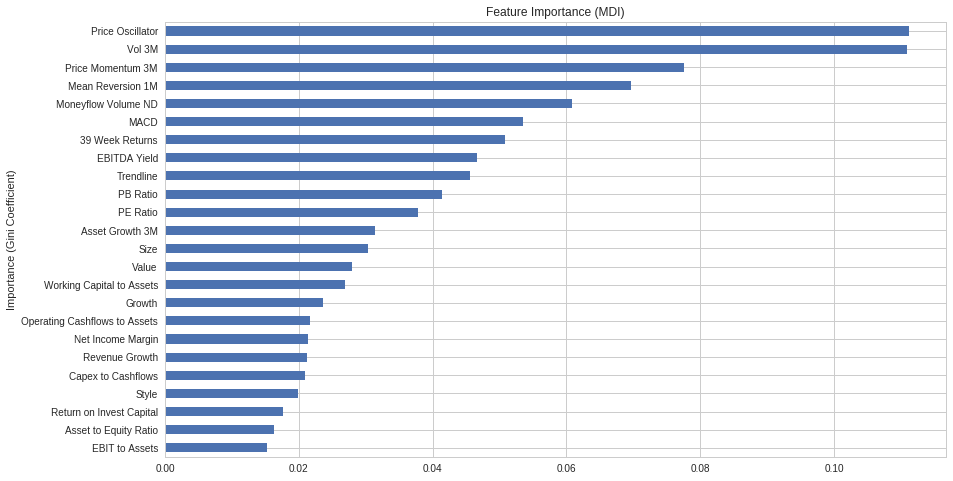

In [26]:
feature_importances = pd.Series(model.feature_importances_, index=results.columns)
feature_importances.sort_values(inplace=True)
ax = feature_importances.plot.barh()
ax.set(ylabel='Importance (Gini Coefficient)', title='Feature importances');
ax.set_title('Feature Importance (MDI)')

### Using the model to make trading decision
Suppose we want to make tradings based on predicted rate of returns, we can just retrieve the predicors values using the same pipeline.

In [27]:
start, end = '2020-06-22', '2020-06-22'
results_to_trade = run_pipeline(pipeline, start_date=start, end_date=end)

In [28]:
results_to_trade.tail(5)

39 Week Returns  \
2020-06-22 00:00:00+00:00 Equity(53256 [CHWY])         0.579460   
                          Equity(53271 [WORK])         0.077048   
                          Equity(53478 [SDC])               NaN   
                          Equity(53511 [DDOG])              NaN   
                          Equity(53535 [PTON])              NaN   

                                                Asset Growth 3M  \
2020-06-22 00:00:00+00:00 Equity(53256 [CHWY])         0.204917   
                          Equity(53271 [WORK])         0.497221   
                          Equity(53478 [SDC])         -0.042768   
                          Equity(53511 [DDOG])         0.027566   
                          Equity(53535 [PTON])        -0.005727   

                                                Asset to Equity Ratio  \
2020-06-22 00:00:00+00:00 Equity(53256 [CHWY])              -2.832963   
                          Equity(53271 [WORK])               2.616963   
                          Equity(53478 [SDC])                2.671541   
                          Equity(53511 [DDOG])               1.328512   
                          Equity(53535 [PTON])               1.693403   

                                                Capex to Cashflows  \
2020-06-22 00:00:00+00:00 Equity(53256 [CHWY])            1.950167   
                          Equity(53271 [WORK])           -1.370079   
                          Equity(53478 [SDC])             0.285461   
                          Equity(53511 [DDOG])           -0.255955   
                          Equity(53535 [PTON])            1.350220   

                                                EBIT to Assets  EBITDA Yield  \
2020-06-22 00:00:00+00:00 Equity(53256 [CHWY])       -0.169084 -3.200080e+06   
                          Equity(53271 [WORK])       -0.132391 -7.816843e+06   
                          Equity(53478 [SDC])        -0.478452 -4.520704e+07   
                          Equity(53511 [DDOG])        0.014168  3.449295e+05   
                          Equity(53535 [PTON])       -0.090916 -3.727148e+06   

                                                Growth      MACD  \
2020-06-22 00:00:00+00:00 Equity(53256 [CHWY])     NaN  2.059893   
                          Equity(53271 [WORK])     NaN -0.127238   
                          Equity(53478 [SDC])      NaN  0.108395   
                          Equity(53511 [DDOG])     NaN  3.711024   
                          Equity(53535 [PTON])     NaN  1.293383   

                                                Mean Reversion 1M  \
2020-06-22 00:00:00+00:00 Equity(53256 [CHWY])           1.244506   
                          Equity(53271 [WORK])           0.244668   
                          Equity(53478 [SDC])            0.073666   
                          Equity(53511 [DDOG])           0.461667   
                          Equity(53535 [PTON])           0.050292   

                                                Moneyflow Volume ND  \
2020-06-22 00:00:00+00:00 Equity(53256 [CHWY])             0.448106   
                          Equity(53271 [WORK])            -0.173277   
                          Equity(53478 [SDC])             -0.019692   
                          Equity(53511 [DDOG])             0.091756   
                          Equity(53535 [PTON])            -0.186608   

                                                          ...              \
2020-06-22 00:00:00+00:00 Equity(53256 [CHWY])            ...               
                          Equity(53271 [WORK])            ...               
                          Equity(53478 [SDC])             ...               
                          Equity(53511 [DDOG])            ...               
                          Equity(53535 [PTON])            ...               

                                                Price Momentum 3M  \
2020-06-22 00:00:00+00:00 Equity(53256 [CHWY])           0.564717   
                          Equity(53271 [WORK])   

In [29]:
data_to_trade = results_to_trade.dropna()
index_to_ticker = data_to_trade.index.levels[1]
profit_pred = model.predict(np.array(results_to_trade.dropna()))
profit_pred_dup = profit_pred.copy()

Using heap in Python, we can efficiently get the put asstes in our list for long and short. We take long position on the top 10 assets, and short positions on the bottom 10 assets, with equal amount of money.

In [30]:
import heapq
top_n, bottom_n = 10, 10
longs = heapq.nlargest(top_n, range(len(profit_pred)), profit_pred.take)
shorts = heapq.nlargest(top_n, range(len(profit_pred)), ((-1)*profit_pred).take)

longs_tickers = [index_to_ticker[l] for l in longs]
shorts_tickers = [index_to_ticker[s] for s in shorts]

In [31]:
print("Assets to long today:")
print(longs_tickers)

print("Assets to short today:")
print(shorts_tickers)

Assets to long today:
[Equity(579 [ASTE]), Equity(755 [BC]), Equity(24 [AAPL]), Equity(610 [ATNI]), Equity(1751 [COHR]), Equity(980 [BMY]), Equity(392 [AMS]), Equity(1024 [BOKF]), Equity(1988 [CUO]), Equity(1874 [CRS])]
Assets to short today:
[Equity(1117 [BSET]), Equity(368 [AMGN]), Equity(3242 [GSK]), Equity(1068 [BPT]), Equity(2071 [D]), Equity(526 [AROW]), Equity(3213 [GIM]), Equity(2262 [DOV]), Equity(2045 [CYBE]), Equity(2339 [DTF])]
